# Alcohol Abuse Effects on EEG Data
## Neural Data Science Final Project

### Will Kersh​
### Dylan Cullifer​
### Isabell Cook

# Imports and Sample Data

In [1]:
import pandas as pd
import numpy as np
import mne
import mne.viz
from mne.viz import plot_topomap
from mne.datasets import eegbci
from mne.io import concatenate_raws, read_raw_edf
from mne.channels import make_standard_montage
import scipy as sp
from scipy import stats
import matplotlib.pyplot as plt
import matplotlib
import copy
from scipy.signal import hilbert
import os
from tqdm import tqdm

# Path names
path_dir_train = 'eeg+database/SMNI_CMI_TRAIN/'
path_dir_test = 'eeg+database/SMNI_CMI_TEST/'

# one alcoholic patient and one control with same condition
alc_1 = pd.read_csv("eeg+database/SMNI_CMI_TRAIN/Data1.csv")
control_236 = pd.read_csv("eeg+database/SMNI_CMI_TRAIN/Data236.csv")

alc_1.head()

,Unnamed: 0,trial number,sensor position,sample num,sensor value,subject identifier,matching condition,channel,name,time
0,5,0,FP1,0,-8.921,a,S1 obj,0,co2a0000364,0.000000
1,6,0,FP1,1,-8.433,a,S1 obj,0,co2a0000364,0.003906
2,7,0,FP1,2,-2.574,a,S1 obj,0,co2a0000364,0.007812
3,8,0,FP1,3,5.239,a,S1 obj,0,co2a0000364,0.011719
4,9,0,FP1,4,11.587,a,S1 obj,0,co2a0000364,0.015625


# Load data
This code enumerates over all of the training data files to load them in to our EEG_data object

In [2]:
file_names = [f for f in os.listdir('eeg+database/SMNI_CMI_TRAIN/') if f.endswith('.csv')]
EEG_data = pd.DataFrame({}) # create an empty data frame that will hold data from each file

for file_name in tqdm(file_names):
    temp_df = pd.read_csv('eeg+database/SMNI_CMI_TRAIN/' + file_name) # used to read each file into EEG_data
    EEG_data = pd.concat([EEG_data, temp_df], ignore_index=True)      # add the file data to the main data frame
    
EEG_data = EEG_data.drop(['Unnamed: 0'], axis=1)                      # remove the unused column
EEG_data.loc[EEG_data['matching condition'] == 'S2 nomatch,', 'matching condition'] = 'S2 nomatch' # remove comma from stimulus name

print(f"Loaded {len(file_names)} files")
print(f"Total rows: {len(EEG_data)}")
EEG_data.head()

100%|██████████| 468/468 [02:24<00:00,  3.23it/s]


Loaded 468 files
Total rows: 7667712


,trial number,sensor position,sample num,sensor value,subject identifier,matching condition,channel,name,time
0,0,FP1,0,-8.921,a,S1 obj,0,co2a0000364,0.000000
1,0,FP1,1,-8.433,a,S1 obj,0,co2a0000364,0.003906
2,0,FP1,2,-2.574,a,S1 obj,0,co2a0000364,0.007812
3,0,FP1,3,5.239,a,S1 obj,0,co2a0000364,0.011719
4,0,FP1,4,11.587,a,S1 obj,0,co2a0000364,0.015625


In [3]:
control_236.head()

,Unnamed: 0,trial number,sensor position,sample num,sensor value,subject identifier,matching condition,channel,name,time
0,5,0,FP1,0,3.082,c,S1 obj,0,co2c0000337,0.000000
1,6,0,FP1,1,2.594,c,S1 obj,0,co2c0000337,0.003906
2,7,0,FP1,2,2.106,c,S1 obj,0,co2c0000337,0.007812
3,8,0,FP1,3,2.106,c,S1 obj,0,co2c0000337,0.011719
4,9,0,FP1,4,3.571,c,S1 obj,0,co2c0000337,0.015625


### Some Pre-processing

Creating RawArray with float64 data, n_channels=61, n_times=256
    Range : 0 ... 255 =      0.000 ...     0.996 secs
Ready.
Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 1 - 50 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 1.00
- Lower transition bandwidth: 1.00 Hz (-6 dB cutoff frequency: 0.50 Hz)
- Upper passband edge: 50.00 Hz
- Upper transition bandwidth: 12.50 Hz (-6 dB cutoff frequency: 56.25 Hz)
- Filter length: 32769 samples (128.004 s)



C:\Users\isabe\AppData\Local\Temp\ipykernel_9832\1850864053.py:30: RuntimeWarning: filter_length (32769) is longer than the signal (256), distortion is likely. Reduce filter length or filter a longer signal.
  mne_data.filter(l_freq=1.0, h_freq=50.0, filter_length='128s')


NOTE: plot_psd() is a legacy function. New code should use .compute_psd().plot().
Effective window size : 1.000 (s)
Plotting power spectral density (dB=True).


c:\Users\isabe\Documents\CS 5723 _ NDS\NDS_Project\.venv\Lib\site-packages\mne\viz\utils.py:160: UserWarning: FigureCanvasAgg is non-interactive, and thus cannot be shown
  (fig or plt).show(**kwargs)


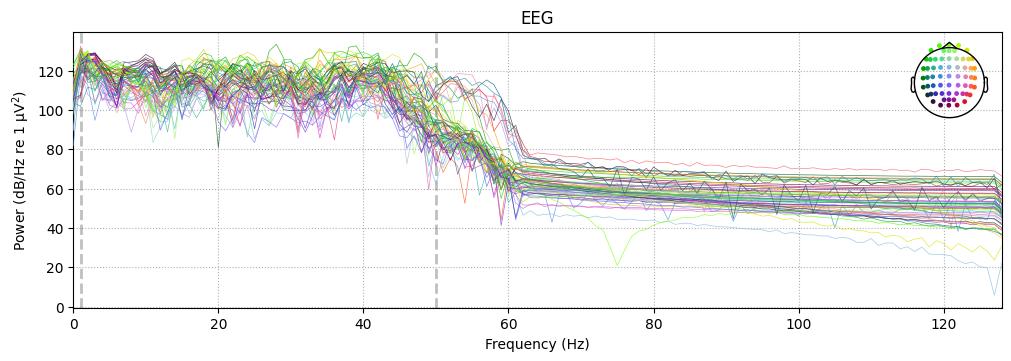

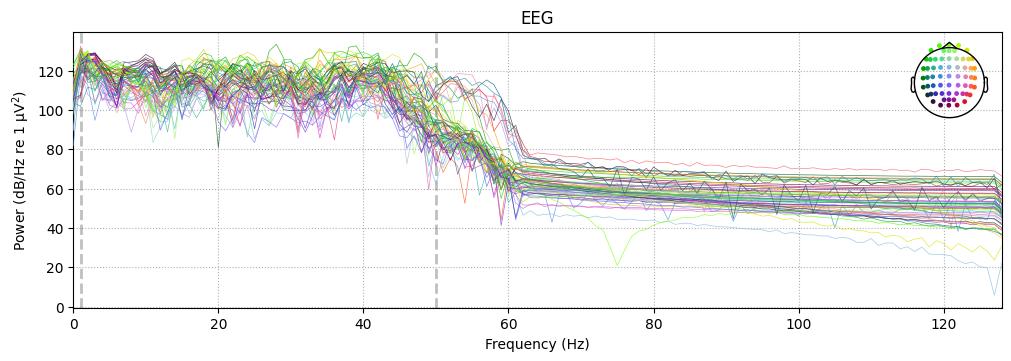

In [4]:

def csv_to_eeg_data(csv_file):
    data = pd.read_csv(csv_file)
    # Remove the positions that don't conform to the international 10-20 system.
    data = data.drop(data[data["sensor position"].isin(["X", "Y", "nd"])].index)

    # sensor placement names error out unless you fix them
    data["sensor position"] = data["sensor position"].replace({'FP1': 'Fp1', 'FP2': 'Fp2',
                                                               'FZ': 'Fz', 'CZ': 'Cz',
                                                               'PZ': 'Pz', 'FPZ': 'Fpz',
                                                               'AFZ': 'AFz', 'FCZ': 'FCz',
                                                               'POZ': 'POz', 'OZ': 'Oz',
                                                               'CPZ': 'CPz'})

    # get pos names
    sensor_pos = list(data["sensor position"].unique())
    # extract only needed eeg data
    subset = data[["channel", "sensor value", "sample num"]]
    # flip into channels x time 
    formatted = subset.pivot(index="channel", columns="sample num", values="sensor value").sort_index(axis=1)
    new_data = formatted.to_numpy()

    # convert to mne data and set channels
    channels_sfreq = mne.create_info(ch_names=sensor_pos, sfreq=256, ch_types="eeg")
    mne_data = mne.io.RawArray(new_data, channels_sfreq)

    mne_data.set_montage(mne.channels.make_standard_montage('standard_1020'))
    
    # Apply 1-50 Hz band-pass filter with shorter filter length to avoid distortion
    # Use filter length of ~0.5 seconds (128 samples) which is shorter than signal length
    mne_data.filter(l_freq=1.0, h_freq=50.0, filter_length='128s')

    return mne_data


alc_test = csv_to_eeg_data("eeg+database/SMNI_CMI_TRAIN/Data1.csv")
alc_test.plot_psd()

## Load in all CSV Train data and preprocess

metadata: \
    &emsp;`trail`\
    &emsp;`group`: \
        &emsp;&emsp;`a` for alcohol\
        &emsp;&emsp;`c` for control\
    &emsp;`condition`: \
        &emsp;&emsp;'S1 obj'\
        &emsp;&emsp;'S2 match' \
        &emsp;&emsp;'S2 nomatch'\
    &emsp;`name`: subject's name

In [7]:
"""
    Read in all csvs in a directory and put them into mne.EpochsArray
"""
def read_csv_epoch(dir_path, sfreq=256.0):
    file_names = [f for f in os.listdir(dir_path) if f.endswith('.csv')]
    # Define variables to use to create MNE
    datas_2d = []
    metas = []
    ch_names = None
    for f in tqdm(file_names):
        temp_df = pd.read_csv(dir_path + f)
        
        # Setup mne Matrix (channel, time)
        ## make key for this sample = time (time is the unique value)
        temp_df_time = temp_df.pivot(index='time', columns='sensor position', values='sensor value')
        ## convert to 2D numpy (time, channel)
        temp_2d = temp_df_time.to_numpy()
        ## Transpose to (channel, time)
        temp_2d = temp_2d.T
        
        # Save metadata from CSV into meta
        meta = {
            "trial": int(temp_df["trial number"].iloc[0]),
            "group": str(temp_df["subject identifier"].iloc[0]),   # 'a' or 'c' for 'alcohol' or 'control'
            "condition": str(temp_df["matching condition"].iloc[0]), # 'S1 obj', 'S2 match', or 'S2 nomatch'
            "name": str(temp_df["name"].iloc[0]),
        }
        
        # Check Channel names (Should be same for all trails)
        channels = list(temp_df_time.columns)
        if ch_names is None:
            ch_names = channels
        elif ch_names != channels: 
            print(f"{dir_path}{f} has different channels and was excluded.\n\tExpected: {ch_names}\n\tGot: {channels}")
            continue
        
        # Save data to use to create mne epoch array
        datas_2d.append(temp_2d)
        metas.append(meta)
        
    # Create 3D np array (epoch, channel, time)
    datas_3d = np.stack(datas_2d, axis=0)
    
    # Build mne info 
    ## Define type of channel - dataset has some channels that are not typical in eeg
    ch_names_filtered = ["misc" if c in ["X", "Y", "nd"] else "eeg" for c in ch_names]
    ## Create mne info object
    mne_info = mne.create_info(ch_names=ch_names, sfreq=sfreq, ch_types=ch_names_filtered)
    ## set montage to standard_1020
    mne_info.set_montage(mne.channels.make_standard_montage('standard_1020'), match_case=False, on_missing="ignore")
    
    # Convert metadata into a dataframe 
    metas_df = pd.DataFrame(metas)
    
    # Create events from "matching condition" in the dataset
    ## Grab unique conditions - should just be 'S1 obj', 'S2 match', or 'S2 nomatch'
    conditions = sorted(metas_df["condition"].unique())
    ## Map to an integer code
    event_ids = {cond: i+1 for i, cond in enumerate(conditions)}
    ## Map epochs to events
    event_codes = metas_df["condition"].map(event_ids).to_numpy()
    # Grab number of epochs
    n_epochs = datas_3d.shape[0]
    # Create events
    events = np.c_[np.arange(n_epochs), np.zeros(n_epochs, int), event_codes]
    
    # Create EpochsArray
    epochs = mne.EpochsArray(
        data=datas_3d,
        info=mne_info,
        events=events,
        event_id=event_ids,
        tmin=0.0,
        metadata=metas_df
    )
    
    # Print some verification statements
    print(f"CSV Files Found: {len(file_names)}")
    print(f"Epochs Loaded: {len(epochs)}")
    print(f"Number of files not loaded (missing data): {len(file_names) - len(epochs)}")
    print(f"Shape of epochs: {epochs.get_data().shape}")
    print(f"Metadata length matches epoch length: {len(epochs.metadata) == len(epochs)}")
    print(f"Number of Trials found:{epochs.metadata["trial"].nunique()}")
    print(f"Number of Subjects found: {epochs.metadata["name"].nunique()}")
    print(f"Conditions found: {epochs.metadata["condition"].unique()}")
    print(f"Groups found: {epochs.metadata["group"].unique()}")
    return epochs
        
epochs_train = read_csv_epoch(path_dir_train)
epochs_test = read_csv_epoch(path_dir_test)

# Merge the two via their metadata
## Concatenate teh epochs
epochs_merged = mne.concatenate_epochs([epochs_train, epochs_test])
## Drop duplicated metadata rows
unique_metadata = ~epochs_merged.metadata.duplicated()
## keep only epochs with unique data
epochs = epochs_merged[unique_metadata.to_numpy()]

print(epochs_train.get_data().shape)
print(epochs_test.get_data().shape)
print(epochs.get_data().shape)

# Apply 1-50 Hz band-pass filter with shorter filter length to avoid distortion
# Use filter length of ~0.5 seconds (128 samples) which is shorter than signal length
epochs_merged.filter(l_freq=1.0, h_freq=50.0)
epochs.filter(l_freq=1.0, h_freq=50.0)
        

100%|██████████| 468/468 [00:19<00:00, 24.46it/s]


Adding metadata with 4 columns
468 matching events found
No baseline correction applied
0 projection items activated
CSV Files Found: 468
Epochs Loaded: 468
Number of files not loaded (missing data): 0
Shape of epochs: (468, 64, 256)
Metadata length matches epoch length: True
Number of Trials found:62
Number of Subjects found: 16
Conditions found: ['S1 obj' 'S2 nomatch,' 'S2 match']
Groups found: ['a' 'c']


100%|██████████| 480/480 [00:19<00:00, 24.21it/s]


Adding metadata with 4 columns
480 matching events found
No baseline correction applied
0 projection items activated
CSV Files Found: 480
Epochs Loaded: 480
Number of files not loaded (missing data): 0
Shape of epochs: (480, 64, 256)
Metadata length matches epoch length: True
Number of Trials found:66
Number of Subjects found: 16
Conditions found: ['S1 obj' 'S2 nomatch,' 'S2 match']
Groups found: ['a' 'c']
Adding metadata with 4 columns
948 matching events found
No baseline correction applied
(468, 64, 256)
(480, 64, 256)
(924, 64, 256)
Setting up band-pass filter from 1 - 50 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 1.00
- Lower transition bandwidth: 1.00 Hz (-6 dB cutoff frequency: 0.50 Hz)
- Upper passband edge: 50.00 Hz
- Upper transition bandwidth: 12.50 Hz (-6 dB cutoff 

C:\Users\isabe\AppData\Local\Temp\ipykernel_9832\119024203.py:106: RuntimeWarning: filter_length (845) is longer than the signal (256), distortion is likely. Reduce filter length or filter a longer signal.
  epochs_merged.filter(l_freq=1.0, h_freq=50.0)


Setting up band-pass filter from 1 - 50 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 1.00
- Lower transition bandwidth: 1.00 Hz (-6 dB cutoff frequency: 0.50 Hz)
- Upper passband edge: 50.00 Hz
- Upper transition bandwidth: 12.50 Hz (-6 dB cutoff frequency: 56.25 Hz)
- Filter length: 845 samples (3.301 s)



C:\Users\isabe\AppData\Local\Temp\ipykernel_9832\119024203.py:107: RuntimeWarning: filter_length (845) is longer than the signal (256), distortion is likely. Reduce filter length or filter a longer signal.
  epochs.filter(l_freq=1.0, h_freq=50.0)


<EpochsArray | 924 events (all good), 0 – 0.996 s (baseline off), ~115.6 MiB, data loaded, with metadata,
 'S1 obj': 320
 'S2 match': 303
 'S2 nomatch,': 301>

### Separating epochs by important factors

In [14]:
def group_epochs_3D(epochs, dim_1, dim_2, dim_3):
    # Create a dict to store 3 nested dicts in:
    data = {}
    # Loop over all unique epochs of 1st dimension attribute
    for dim_1_id in tqdm(sorted(epochs.metadata[dim_1].unique())):
        # Trial is only one that is int
        dim_1_cond = f'{dim_1} == "{dim_1_id}"'
        if (dim_1 == "trial"):
            dim_1_id = int(dim_1_id)
            dim_1_cond = f'{dim_1} == {dim_1_id}'
        # Create item in data for given epoch
        data[dim_1_id] = {}
        # Loop over all unique epochs of 2nd dimension attribute
        epochs_dim_1 = epochs[dim_1_cond]
        for dim_2_id in epochs_dim_1.metadata[dim_2].unique():
            # Trial is only one that is int
            dim_2_cond = f'{dim_2} == "{dim_2_id}"'
            if (dim_2 == "trial"):
                dim_2_id = int(dim_2_id)
                dim_2_cond = f'{dim_2} == {dim_2_id}'
            # Create item in data for given 2 attributes
            data[dim_1_id][dim_2_id] = {}
            # Grab all epochs with the given 2 attributes
            epochs_dim_2 = epochs[f'{dim_1_cond} and {dim_2_cond}']
            # Loop over all unique epochs of 3rd dimension attribute
            for dim_3_id in epochs_dim_2.metadata[dim_3].unique():
                # Trial is only one that is int
                dim_3_cond = f'{dim_3} == "{dim_3_id}"'
                if (dim_3 == "trial"):
                    dim_3_id = int(dim_3_id)
                    dim_3_cond = f'{dim_3} == {dim_3_id}'
                epochs_dim_3 = epochs[f'{dim_1_cond} and {dim_2_cond} and {dim_3_cond}']
                # Store the given data for the 3 attribute values
                data[dim_1_id][dim_2_id][dim_3_id] = epochs_dim_3
    return data

epochs_trial_cond_group = group_epochs_3D(epochs, "trial", "condition", "group")
epochs_cond_group_subject = group_epochs_3D(epochs, "condition", "group", "name")


100%|██████████| 3/3 [00:06<00:00,  2.14s/it]


In [20]:
print(epochs_cond_group_subject)

{'S1 obj': {'a': {'co2a0000364': <EpochsArray | 20 events (all good), 0 – 0.996 s (baseline off), ~2.6 MiB, data loaded, with metadata,
 'S1 obj': 20>, 'co2a0000369': <EpochsArray | 20 events (all good), 0 – 0.996 s (baseline off), ~2.6 MiB, data loaded, with metadata,
 'S1 obj': 20>, 'co2a0000370': <EpochsArray | 20 events (all good), 0 – 0.996 s (baseline off), ~2.6 MiB, data loaded, with metadata,
 'S1 obj': 20>, 'co2a0000371': <EpochsArray | 20 events (all good), 0 – 0.996 s (baseline off), ~2.6 MiB, data loaded, with metadata,
 'S1 obj': 20>, 'co2a0000372': <EpochsArray | 20 events (all good), 0 – 0.996 s (baseline off), ~2.6 MiB, data loaded, with metadata,
 'S1 obj': 20>, 'co2a0000375': <EpochsArray | 20 events (all good), 0 – 0.996 s (baseline off), ~2.6 MiB, data loaded, with metadata,
 'S1 obj': 20>, 'co2a0000365': <EpochsArray | 20 events (all good), 0 – 0.996 s (baseline off), ~2.6 MiB, data loaded, with metadata,
 'S1 obj': 20>, 'co2a0000368': <EpochsArray | 20 events (all

#### Test access

In [15]:
print(len(epochs_trial_cond_group))

# print(trial_cond_group_epochs)
# for i, _ in enumerate(epochs_trial_cond_group):
#     print(len(epochs[f'trial == {i}']))
    
print(len(epochs[f'trial == 7']))
print(epochs_trial_cond_group.get(0)["S1 obj"]["a"])
print(epochs_trial_cond_group.get(0)["S1 obj"]["c"])
print(epochs_trial_cond_group.get(0)["S1 obj"]["a"])
print(epochs_trial_cond_group.get(0)["S1 obj"]["c"])
print(epochs_trial_cond_group.get(0)["S1 obj"]["a"].get_data().shape)

92
12
<EpochsArray | 7 events (all good), 0 – 0.996 s (baseline off), ~970 KiB, data loaded, with metadata,
 'S1 obj': 7>
<EpochsArray | 7 events (all good), 0 – 0.996 s (baseline off), ~970 KiB, data loaded, with metadata,
 'S1 obj': 7>
<EpochsArray | 7 events (all good), 0 – 0.996 s (baseline off), ~970 KiB, data loaded, with metadata,
 'S1 obj': 7>
<EpochsArray | 7 events (all good), 0 – 0.996 s (baseline off), ~970 KiB, data loaded, with metadata,
 'S1 obj': 7>
(7, 64, 256)
